In [1]:
import chess
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
import pandas as pd
from our_graph2_encode import move_to_index, encode_node_features, create_batch_from_boards, encode_edge_features, encode_global_node_features, static_edge_index, static_edge_map, base_graph_edges, index_to_move
from scipy.special import softmax

created 64 nodes
created 1792 edge
current state (FEN): r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/RNBQK2R b KQkq - 3 3

encode result:
node matrix shape: (64, 12)
edge matrix shape: (1792, 11)
--- Static Graph Components ---
static_edge_index shape: torch.Size([2, 1792])
static_edge_map shape: torch.Size([1792])
------------------------------


In [2]:
# helper functions
def index_of(arr, value):
    for i in range(len(arr)):
        if arr[i] == value:
            return i
    
    return -1

def rgba_to_hex(r, g, b, a=255):
    r = int(round(np.clip(r, 0, 1) * 255))
    g = int(round(np.clip(g, 0, 1) * 255))
    b = int(round(np.clip(b, 0, 1) * 255))
    a = int(round(np.clip(a, 0, 1) * 255))
    return f'#{r:02X}{g:02X}{b:02X}{a:02X}'

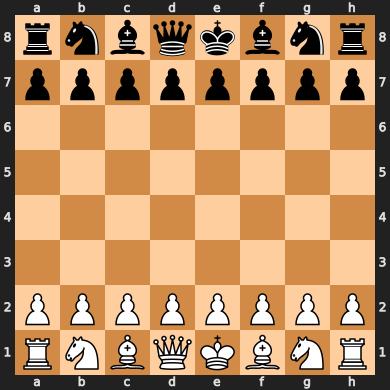

In [3]:
board = chess.Board()

nodes = encode_node_features(board)
edges = encode_edge_features(board, base_graph_edges)
g_features = encode_global_node_features(board)

board

In [4]:
print(nodes.shape)
print(edges.shape)

(64, 12)
(1792, 11)


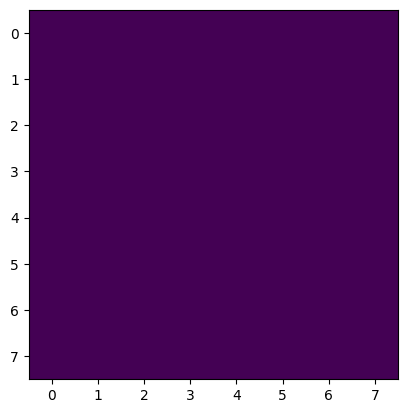

In [5]:
a = np.zeros(64)
a.resize((8, 8))
plt.imshow(a)

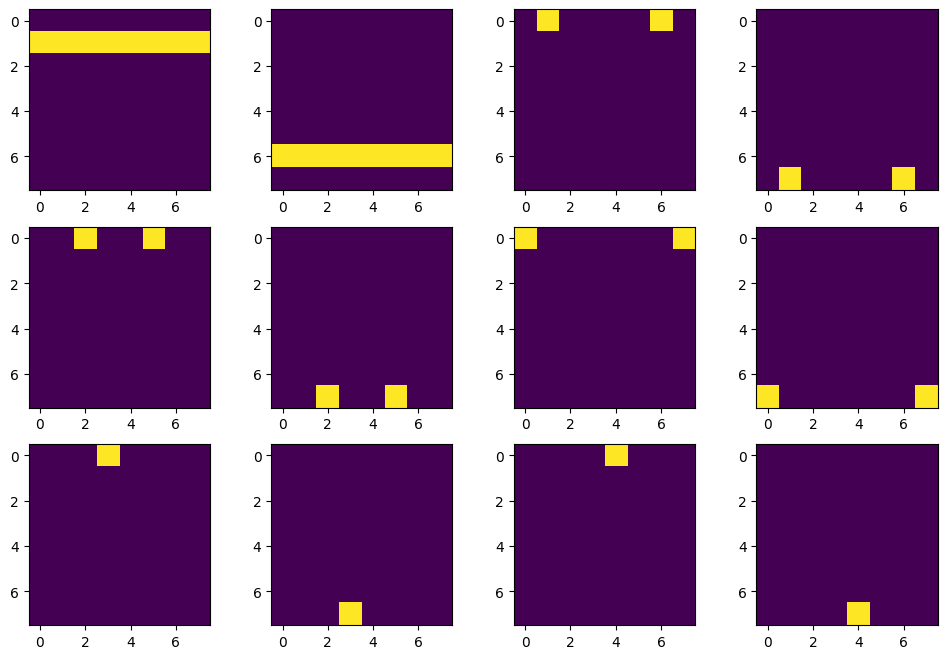

In [6]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(nodes[:, i].reshape(8, 8))

In [7]:
# fig, axs = plt.subplots(3, 4, figsize=(12, 8))

# arr1 = np.zeros((12, 64))

# arr2 = np.random.randint(64, size=(12))
# while len(set(arr2)) != 12:
#     arr2 = np.random.randint(64, size=(12))

# for i in range(len(arr2)):
#     for j in range(edges.shape[1]):
#         index = index_of(arr2, edges[0, j])
#         if index != -1:
#             arr1[index, edges[1, j]] = 1

# for i, ax in enumerate(axs.flat):
#     ax.imshow(arr1[i].reshape(8, 8))



In [8]:
df = pd.read_csv("kingbase_processed_all.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684643 entries, 0 to 684642
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Event       684643 non-null  object
 1   Site        684643 non-null  object
 2   Date        684643 non-null  object
 3   White       684643 non-null  object
 4   Black       684643 non-null  object
 5   Result      684643 non-null  object
 6   WhiteElo    684643 non-null  int64 
 7   BlackElo    684643 non-null  int64 
 8   ECO         684643 non-null  object
 9   TotalMoves  684643 non-null  int64 
 10  Moves_UCI   684643 non-null  object
dtypes: int64(3), object(8)
memory usage: 57.5+ MB


In [10]:
# preprocess
# all_games = []
# for i in range(len(df)):
#     move_str_array = df["Moves_UCI"][i].split(" ")
#     move_uci_array = []
#     for j in range(len(move_str_array)):
#         move_uci_array.append(chess.Move.from_uci(move_str_array[j]))

#     all_games.append(move_uci_array)

In [11]:
def get_board(game_number, move_number):
    all_moves = df["Moves_UCI"]
    move_uci_array = all_moves[game_number].split(" ")
    board = chess.Board()
    for i in range(move_number):
        move = chess.Move.from_uci(move_uci_array[i])
        board.push(move)

    return board

def get_move_from_dataset(game_number, move_number):
    return chess.Move.from_uci(df["Moves_UCI"][game_number].split(" ")[move_number])

def get_move_uci_array_from_dataset(game_number):
    return df["Moves_UCI"][game_number].split(" ")

In [12]:
game_number = 0
move_number = 0

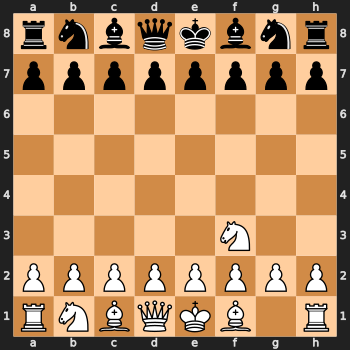

In [24]:
# arrows

board = get_board(game_number, move_number)
svg = chess.svg.board(
    board,
    # arrows=[chess.svg.Arrow(move.from_square, move.to_square, color="#0000cccc")],
    size=350,
) 

move_number += 1

svg

1-0
False


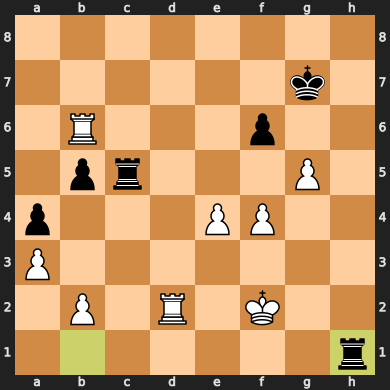

In [14]:
ran = np.random.randint(len(df))

all_moves = df["Moves_UCI"]
move_uci_array = all_moves[ran].split(" ")

board = get_board(ran, len(move_uci_array) - 1)

print(df["Result"][ran])
print(board.is_checkmate())
board

In [15]:
# initialize hello world
from helloworld_model2 import start_model, model_predict
board = chess.Board()
model = start_model()

def get_model_move(board):
    pred_moves, pred_eval = model_predict(model, board)
    return index_to_move[np.argmax(pred_moves)]

def get_model_legal_move(board):
    pred_moves, pred_eval = model_predict(model, board)
    sorted_moves = np.flip(np.argsort(pred_moves[0]))
    for i in range(len(sorted_moves)):
        if index_to_move[sorted_moves[i]] in board.legal_moves:
            return index_to_move[sorted_moves[i]]


Using device: cpu


d:\programming\github\Advance_Machine_Learning_Project\helloworld_model2.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_lo

e2e4


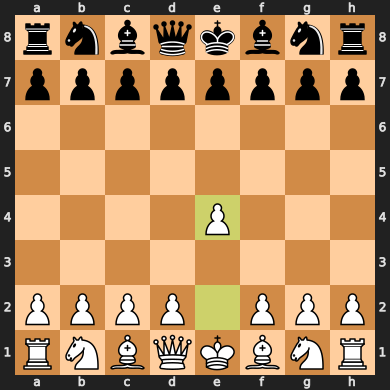

In [16]:
# hello world

pred_moves, pred_eval = model_predict(model, board)
print(index_to_move[np.argmax(pred_moves)])

board.push(index_to_move[np.argmax(pred_moves)])
board

In [17]:
# # check correct rate

# counter1 = 0
# counter2 = 0

# for i in range(3):
#     board = chess.Board()
#     for j in range(len(get_move_uci_array_from_dataset(i))):
#         dataset_move = get_move_from_dataset(i, j)
#         model_move = get_model_move(board)

#         # print(get_model_move(board), end=" ")
#         # print(get_move_from_dataset(i, j))

#         # print(dataset_move in board.legal_moves)
#         # print(model_move in board.legal_moves)

#         if (model_move == dataset_move):
#             counter1 += 1
        
#         counter2 += 1

#         board.push(dataset_move)

#     print(f"correct rate: {counter1 / counter2}")

In [18]:
ran = np.random.randint(len(df))
counter = 0
print(ran)
board = chess.Board()

676960


is checkmate: False
is stalemate: False


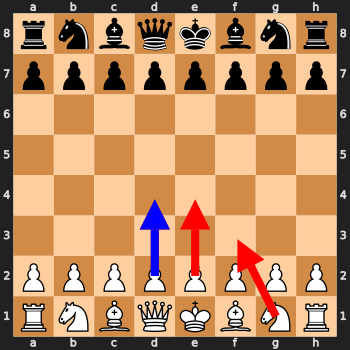

In [19]:
print(f"is checkmate: {board.is_checkmate()}")
print(f"is stalemate: {board.is_stalemate()}")
if (not (board.is_checkmate() or board.is_stalemate() or counter == 0)):
    board.push(dataset_move)

dataset_move = get_move_from_dataset(ran, counter)
model_move = get_model_move(board)
model_move_vec, eval = model_predict(model, board)
top_moves = [index_to_move[a] for a in np.flip(np.argsort(model_move_vec[0]))[:3]]

svg = chess.svg.board(
    board,
    arrows=[
        chess.svg.Arrow(top_moves[0].from_square, top_moves[0].to_square, color="#ff0000ff"),
        chess.svg.Arrow(top_moves[1].from_square, top_moves[1].to_square, color="#ff0000bf"),
        chess.svg.Arrow(top_moves[2].from_square, top_moves[2].to_square, color="#ff00007e"),
        chess.svg.Arrow(dataset_move.from_square, dataset_move.to_square, color=rgba_to_hex(0, 0, 1, 1)),
    ],
    size=350,
) 
counter += 1
svg

In [20]:
ran = np.random.randint(len(df))
counter = 0
print(f"game number: {ran}")
board = chess.Board()

game number: 449909


is checkmate: False
is stalemate: False


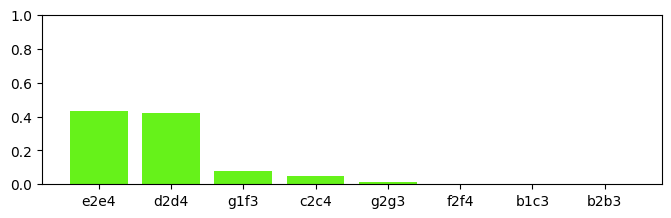

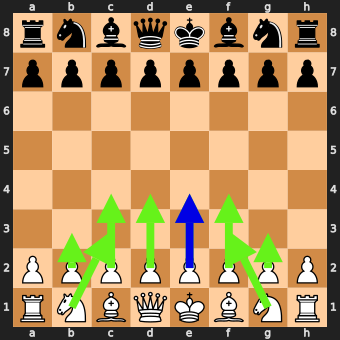

In [21]:
n = 8

print(f"is checkmate: {board.is_checkmate()}")
print(f"is stalemate: {board.is_stalemate()}")
if (not (board.is_checkmate() or board.is_stalemate() or counter == 0)):
    board.push(dataset_move)

dataset_move = get_move_from_dataset(ran, counter)
model_move_vec, eval = model_predict(model, board)
index_array = np.flip(np.argsort(model_move_vec[0]))[:n]
top_moves = [index_to_move[a] for a in index_array]
softmax_array = softmax(model_move_vec[0])
alphas = softmax_array[index_array]

colors = []
arrows = []
for i in range(n):
    if top_moves[i] in board.legal_moves:
        color = rgba_to_hex(0.4, 0.95, 0.1, 2.25 * alphas[i])
        arrows.append(chess.svg.Arrow(top_moves[i].from_square, top_moves[i].to_square, color=color))
        colors.append((0.4, 0.95, 0.1))
    else:
        color = rgba_to_hex(0.95, 0.1, 0.1, 2.25 * alphas[i])
        arrows.append(chess.svg.Arrow(top_moves[i].from_square, top_moves[i].to_square, color=color))    
        colors.append((0.95, 0.1, 0.1))   
arrows.append(chess.svg.Arrow(dataset_move.from_square, dataset_move.to_square, color="#0000e470"))

plt.figure(figsize=(8,2.2))
plt.ylim((0, 1))
plt.bar([move.uci() for move in top_moves], alphas, color=colors)
plt.show()

svg = chess.svg.board(
    board,
    arrows=arrows,
    size=340,
) 
counter += 1
svg

In [22]:
board = chess.Board(fen="k7/8/8/8/8/8/8/K1QQ4 w - - 0 1")
counter = 0

is checkmate: False
is stalemate: False


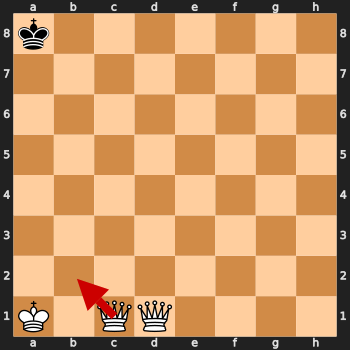

In [23]:
print(f"is checkmate: {board.is_checkmate()}")
print(f"is stalemate: {board.is_stalemate()}")
if (not (board.is_checkmate() or board.is_stalemate() or counter == 0)):
    board.push(model_move)
counter += 1

model_move = get_model_legal_move(board)

svg = chess.svg.board(
    board,
    arrows=[
        chess.svg.Arrow(model_move.from_square, model_move.to_square, color="#cc0000cc", )
    ],
    size=350,
) 
svg